In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import string, os
import re
import nltk
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [71]:
recs = pd.read_csv('verified_recs.csv', header=None).dropna()
recs.columns = ["d_id", "doc_name", "recs"]

In [73]:
recs['d_id'].value_counts() #normalize=True) * 100

23.0    566
4.0      54
3.0      43
7.0      33
1.0      28
6.0      15
11.0     13
8.0      11
19.0     10
12.0      9
20.0      8
2.0       7
17.0      6
21.0      6
16.0      5
15.0      4
10.0      3
22.0      2
Name: d_id, dtype: int64

In [74]:
test_ids = [19, 12, 20, 2, 17, 21, 16, 15, 10, 22, 6]
len(test_ids)

11

In [75]:
test = recs.loc[recs.d_id.isin(test_ids)].recs
train = recs.loc[~recs.d_id.isin(test_ids)].recs

In [76]:
train.shape[0], test.shape[0]

(748, 75)

In [77]:
recs

,d_id,doc_name,recs
0,1.0,ED586970.pdf,School districts must ensure that personally i...
1,1.0,ED586970.pdf,Identify and recognize risks and vulnerabiliti...
2,1.0,ED586970.pdf,Design systems and services with a design-for-...
3,1.0,ED586970.pdf,Consider the benefits of a diverse combination...
4,1.0,ED586970.pdf,Leverage partnerships with agencies and extern...
...,...,...,...
846,23.0,CSC-Final-Report,To fully understand and prepare to counter the...
847,23.0,CSC-Final-Report,This assessment should include the \nfollowing...
848,23.0,CSC-Final-Report,This assessment should include the \nfollowing...
849,23.0,CSC-Final-Report,This assessment should include the \nfollowing...


In [78]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shubham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter
stopwords = nltk.corpus.stopwords.words('english')

def plot_top_ngrams_barchart(text, n):
    stop=set(stopwords)

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for sentence in new for word in sentence]

    def _get_top_ngram(corpus, n):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

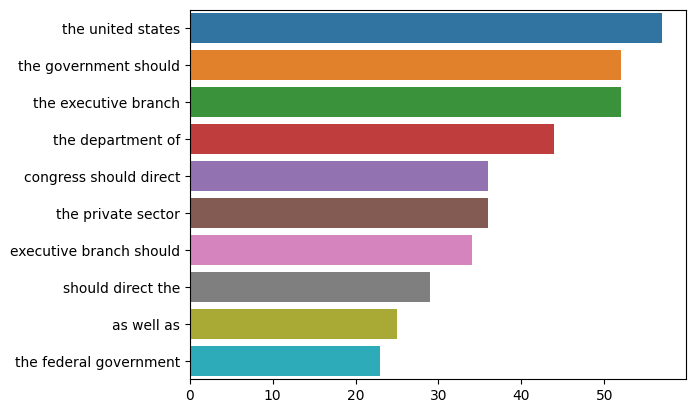

In [80]:
plot_top_ngrams_barchart(recs.recs, n=3)

In [81]:
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models as gensim
import pyLDAvis
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

def get_lda_objects(text):   
    stop=set(nltk.corpus.stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [82]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/shubham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/shubham/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/shubham/nltk_data...


True

In [83]:
lda_model, bow_corpus, dic = get_lda_objects(recs.recs)

In [84]:
lda_model.show_topics()

[(0,
  '0.012*"risk" + 0.008*"The" + 0.008*"program" + 0.008*"Cybersecurity" + 0.007*"intelligence" + 0.006*"threat" + 0.006*"government" + 0.006*"security" + 0.006*"including" + 0.006*"ensure"'),
 (1,
  '0.009*"The" + 0.009*"security" + 0.008*"National" + 0.007*"government" + 0.007*"Congress" + 0.007*"cybersecurity" + 0.007*"risk" + 0.007*"cyber" + 0.006*"Cybersecurity" + 0.006*"U.S."'),
 (2,
  '0.017*"Congress" + 0.009*"government" + 0.008*"U.S." + 0.008*"cybersecurity" + 0.008*"cyber" + 0.008*"establish" + 0.007*"agency" + 0.007*"data" + 0.006*"federal" + 0.006*"Cyber"'),
 (3,
  '0.020*"cyber" + 0.013*"The" + 0.010*"National" + 0.008*"Congress" + 0.008*"government" + 0.008*"States" + 0.007*"security" + 0.007*"United" + 0.007*"U.S." + 0.006*"critical"')]

In [85]:
pyLDAvis.enable_notebook()
vis = gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.029915 -0.071721       1        1  29.794549
3      0.063931 -0.014182       2        1  27.785082
0     -0.107927 -0.015103       3        1  24.025978
1      0.014081  0.101006       4        1  18.394391, topic_info=               Term        Freq       Total Category  logprob  loglift
30             risk   76.000000   76.000000  Default  30.0000  30.0000
304           cyber  147.000000  147.000000  Default  29.0000  29.0000
540   Cybersecurity   54.000000   54.000000  Default  28.0000  28.0000
861            name   18.000000   18.000000  Default  27.0000  27.0000
751    intelligence   33.000000   33.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
480        critical   11.446378   68.611430   Topic4  -5.4832  -0.0977
238           Cyber   11.081919   68.052269   Topic4  -5.5156  -0.1218
191            also    8.493844   37.377415   Topic4  -5.7815   0.2114
484        national    8.922868   62.253126   Topic4  -5.7323  -0.2495
1396         branch    8.682173   49.050020   Topic4  -5.7596  -0.0384

[319 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
613       4  0.952968  Accountability
565       2  0.141339     Acquisition
565       4  0.848035     Acquisition
1490      4  0.844120        Actively
1536      1  0.117612          Agency
...     ...       ...             ...
205       2  0.136670            work
205       3  0.519347            work
205       4  0.164004            work
588       2  0.158361       workforce
588       4  0.791804       workforce

[542 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

In [16]:
# WHO NEEDS WORDCLOUDS ANYWAY

# from wordcloud import WordCloud

# def plot_wordcloud(text):
#     stop=set(nltk.corpus.stopwords.words('english'))

#     def _preprocess_text(text):
#         corpus=''
#         stem=PorterStemmer()
#         lem=WordNetLemmatizer()
#         for news in text:
#             words=[w for w in word_tokenize(news) if (w not in stop)]

#             words=[lem.lemmatize(w) for w in words if len(w)>2]

#             corpus += ' '.join(words)
#         return corpus
    
#     corpus=_preprocess_text(text)
    
#     wordcloud = WordCloud(
#         background_color='salmon', colormap='Pastel1',
#         stopwords=stop,
#         max_words=100,
#         max_font_size=30, 
#         scale=3,
#         random_state=1)
    
#     wordcloud=wordcloud.generate(corpus)

#     fig = plt.figure(1, figsize=(20, 15))
#     plt.axis('off')
 
#     plt.imshow(wordcloud)
#     plt.show()

# plot_wordcloud(df['Recommendation text'])

## Sentence embeddings

In [86]:
import seaborn as sns
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [88]:
sentences = train.to_numpy()
sentence_embeddings = sbert_model.encode(sentences)

In [89]:
sentence_embeddings.shape

(748, 768)

### Cosine Similarity

In [90]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

matrix = np.identity(sentence_embeddings.shape[0])
for i in range(matrix.shape[0]):
  for j in range(i,matrix.shape[0]):
    matrix[i][j] = cosine(sentence_embeddings[i],sentence_embeddings[j])
    matrix[j][i] = matrix[i][j]

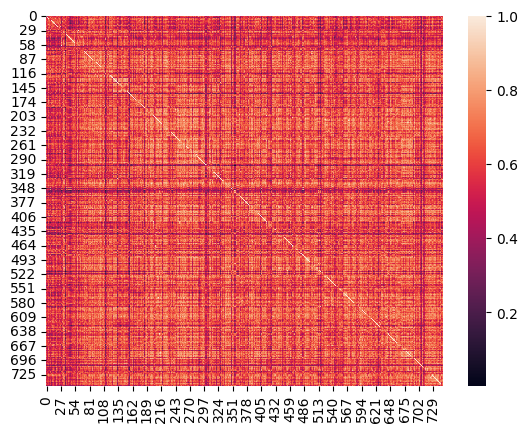

In [91]:
ax = sns.heatmap(matrix)

In [92]:
recomm = np.mean(sentence_embeddings,axis=0)

In [95]:
test_docs = [f"{id}.pdf" for id in test_ids]

In [96]:
from tika import parser

text = ' '.join([parser.from_file(
    os.path.join('..', 'indexed_corpus', doc)
    )['content'].replace('\n','') for doc in test_docs])

2023-11-16 23:15:28,472 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
2023-11-16 23:15:33,523 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar.md5 to /tmp/tika-server.jar.md5.
2023-11-16 23:15:34,017 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [98]:
sentences = nltk.sent_tokenize(text)

In [101]:
from tqdm import tqdm

In [102]:
relevant = []
distances = []

for sentence in tqdm(sentences):
  embedd = sbert_model.encode(sentence)
  distances.append(cosine(recomm, embedd))

100%|██████████| 5691/5691 [02:42<00:00, 34.99it/s]


In [103]:
sorted_idx = sorted(range(len(distances)), key=lambda k: distances[k], reverse=True)
sorted_sentences = np.array(sentences)[sorted_idx]

In [104]:
sorted_distances = sorted(distances, reverse=True)

preds = pd.DataFrame(list(zip(sorted_sentences, sorted_distances)), columns=['Sentence', 'Cosine'])

In [105]:
preds

,Sentence,Cosine
0,"Additionally, the National Cyber Strategy outl...",0.922424
1,The DOD CIO was supposed to leverage existing ...,0.917125
2,(Matter for Consideration 1) Conclusions Matte...,0.912234
3,Federal departments and agencies should give s...,0.906500
4,While the National Cyber Strategy and Implemen...,0.901678
...,...,...
5686,L. No.,0.103927
5687,Less than 10%C.,0.103896
5688,A. NoneB.,0.092115
5689,Less than 1 yearC.,0.088968


In [106]:
import difflib

def retrieve_sentence_index(sentence, sentence_list):
    # Tokenize the sentences
    sentence_tokens = sentence.split()
    sentence_list_tokens = [s.split() for s in sentence_list]
    
    # Calculate the similarity between the sentences
    similarity_scores = [difflib.SequenceMatcher(None, sentence_tokens, s).ratio() for s in sentence_list_tokens]
    
    # Find the index of the most similar sentence
    max_similarity_index = similarity_scores.index(max(similarity_scores))
    
    # Check if the retrieved sentence contains the original sentence
    # retrieved_sentence = sentence_list[max_similarity_index]
    # if sentence in retrieved_sentence:
    #     return max_similarity_index
    # else:
    #     return None
    return max_similarity_index

In [108]:
test_indices = [retrieve_sentence_index(sentence, preds['Sentence']) for sentence in test]
test_preds = preds.iloc[test_indices, :]
final = test_preds.set_index(100 * test_preds.index/len(preds)).sort_index()

In [109]:
final

,Sentence,Cosine
0.035143,(Matter for Consideration 1) Conclusions Matte...,0.912234
0.052715,Federal departments and agencies should give s...,0.906500
0.210859,Congress should consider legislation to design...,0.888485
0.333860,Organizations should use authoritative CVE and...,0.882321
0.527148,Priority efforts should include: • Designating...,0.875260
...,...,...
35.529784,(Recommendation 5) The Director of CISA should...,0.665778
35.828501,"In criminal cases, offer use immunity to one o...",0.663402
46.178176,"Using CVE, CCE, and CPE names supports interop...",0.616459
49.165349,Develop baseline requirements in the planned C...,0.597695


In [110]:
final.Cosine.mean()

0.7813162803649902

In [35]:
test.iloc[:, [1, 3]]

,Recommendation text,indexed_name
36,Federal departments and agencies should period...,12.pdf
37,NIST recommends monitoring systems for vulnera...,12.pdf
38,Agencies should identify the CVE entries that ...,12.pdf
39,Since it is infeasible for an organization to ...,12.pdf
101,Domestic and foreign policy oversight by compe...,9.pdf
102,Technical oversight that includes a “technical...,9.pdf
103,Such oversight also should provide assess- men...,9.pdf
104,Operational oversight with appropriate respons...,9.pdf
105,"Intelligence oversight, including an “intellig...",9.pdf


In [111]:
for i in range(25):
    print(preds.iloc[i, 0])
    print("")

Additionally, the National Cyber Strategy outlined the executive branch’s approach to cybersecurity through a variety of priority actions needed to address the nation’s cybersecurity challenges, such as centralizing management and oversight of federal civilian department and agency network cybersecurity and working with other countries to contribute to greater predictability and stability in cyberspace.

The DOD CIO was supposed to leverage existing authorities and departmental efforts to lead and provide oversight of cybersecurity culture and compliance transformation.

(Matter for Consideration 1) Conclusions Matter for Congressional Consideration Page 35 GAO-20-629  Cybersecurity We are making the following recommendation to the National Security Council: The Chairman of the National Security Council, or his designee, should work with relevant federal entities to update strategy documents related to the nation’s cybersecurity to better reflect desirable characteristics of a national

### Potential Future Steps:

1. Choose any BERT model (RoBERTa?).
2. Get embeddings for modal verbs.
3. Use them to extract general recommendations.
4. Train a recommendation classifier (cyber/non-cyber).
5. Steps 3-4 allow for evalutions to be more systematic.

In [37]:
def extract_modal_sentences(corpus):
    modal_verbs = ["can", "could", "may", "might", "must", "shall", "should", "will", "would"]
    modal_sentences = []
    for sentence in corpus:
        for word in sentence:
            if word.lower() in modal_verbs:
                modal_sentences.append(sentence)
                break
    return modal_sentences